<a href="https://colab.research.google.com/github/filipedmtm/mlpKnnProject/blob/master/pokemon_rarity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokémon Rarity Classification Pipeline
Preprocessing, Imputation, PCA, KNN and MLP classification for Pokémon card rarity prediction.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sns.set(style="whitegrid")


In [3]:
# Load the dataset (replace with actual file path)
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")
file_name = "pokemon-tcg-data-master 1999-2023.csv"
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)


# # Drop rows where rarity is missing and map text to numeric
# df = df.dropna(subset=['rarity'])
# rarity_map = {'Common': 1, 'Uncommon': 2, 'Rare': 3}
# df['rarity'] = df['rarity'].map(rarity_map)




100%|██████████| 1.78M/1.78M [00:00<00:00, 2.10MB/s]

Extracting files...


In [4]:
def extract_attack_info(attack_list_str):
    damage = None
    scale_damage = 0
    converted_energy_cost = None

    try:
        attack_list = eval(attack_list_str)
        if isinstance(attack_list, list) and attack_list:
            first_attack = attack_list[0]

            if 'damage' in first_attack and first_attack['damage']:
                damage_str = str(first_attack['damage'])
                if '+' in damage_str:
                    scale_damage = 1
                damage = ''.join(filter(str.isdigit, damage_str))
                damage = int(damage) if damage else 0

            if 'convertedEnergyCost' in first_attack:
                converted_energy_cost = first_attack['convertedEnergyCost']

    except (SyntaxError, TypeError, IndexError):
        pass

    return damage, scale_damage, converted_energy_cost

def process_subtypes(subtypes_list_str):
    evolution = None
    is_ex = 0
    has_tag = 0

    if isinstance(subtypes_list_str, str):
        try:
            subtypes_list = eval(subtypes_list_str)
            if isinstance(subtypes_list, list):
                for subtype in subtypes_list:
                    subtype_lower = subtype.lower()
                    if subtype in evolution_mapping:
                        if evolution is None or evolution_mapping[subtype] > evolution:
                            evolution = evolution_mapping[subtype]
                    if subtype_lower == 'ex':
                        is_ex = 1
                    elif subtype not in evolution_mapping:
                        has_tag = 1
        except (SyntaxError, TypeError):
            pass

    return evolution, is_ex, has_tag


def is_not_banned(legalities_str):
    if isinstance(legalities_str, str):
        try:
            legalities_dict = eval(legalities_str)
            if isinstance(legalities_dict, dict):
                return all(value != 'Banned' for value in legalities_dict.values())
        except (SyntaxError, TypeError):
            pass
    return True

def extract_resistance_value(resistance_list_str):
    """
    Extracts the resistance 'value' (e.g., -30) from the first resistance in the list.
    Returns 0 if value is missing or if input is not valid.
    """
    resistance_value = 0  # Default to 0
    if isinstance(resistance_list_str, str):
        try:
            resistance_list = eval(resistance_list_str)
            if isinstance(resistance_list, list) and resistance_list:
                first_resistance = resistance_list[0]
                if 'value' in first_resistance:
                    value_str = first_resistance['value']
                    # Remove non-digit characters except '-' and convert to int
                    cleaned = ''.join(filter(lambda x: x.isdigit() or x == '-', value_str))
                    resistance_value = int(cleaned) if cleaned else 0
        except (SyntaxError, TypeError, IndexError, ValueError) as e:
            print(f"Error processing resistance: {resistance_list_str} → {e}")
    return resistance_value

In [5]:
columns_to_remove = ["level",
    "id", "set", "series", "publisher", "release_date", "artist", "evolvesFrom", "evolvesTo",
    "name","abilities", "nationalPokedexNumbers", "set_num", "rules","flavorText", "regulationMark", "ancientTrait"
]
df = df.drop(columns=columns_to_remove)

generation_mapping = {
    'first': 1,
    'second': 2,
    'third': 3,
    'fourth': 4,
    'fifth': 5,
    'sixth': 6,
    'seventh': 7,
    'eighth': 8,
    'ninth': 9
}
df['generation'] = df['generation'].str.lower().map(generation_mapping)

# Filtrar apenas linhas onde 'supertype' é 'Pokémon'
df = df[df['supertype'] == 'Pokémon'].reset_index(drop=True)
df = df.drop(columns=['supertype'])

df[['damage', 'scale_damage', 'convertedEnergyCost']] = df['attacks'].apply(lambda x: pd.Series(extract_attack_info(x)))
df = df.drop(columns=['attacks'])

evolution_mapping = {
    'Basic': 1,
    'Stage 1': 2,
    'Stage 2': 3,
    'LEGEND': 4,
    'MEGA': 5,
    'Ancient': 6
}

df[['evolution', 'is_ex', 'has_tag']] = df['subtypes'].apply(lambda x: pd.Series(process_subtypes(x)))
df = df.drop(columns=['subtypes'])

# Dicionário original de raridades (nome -> categoria genérica)
rarity_mapping = {
    # Common rarities
    'Common': 'Common',
    'Uncommon': 'Uncommon',

    # Rare group
    'Rare': 'Rare',
    'Rare Holo': 'Rare',
    'Rare Prime': 'Rare',
    'Rare BREAK': 'Rare',
    'Radiant Rare': 'Rare',
    'Rare Holo LV.X': 'Rare',

    # Promo
    'Promo': 'Promo',
    'Trainer Gallery Rare Holo': 'Promo',
    'Classic Collection': 'Promo',
    'Illustration Rare': 'Promo',

        # Rare group
    'Rare Holo EX': 'Rare',
    'Rare Holo GX': 'Rare',
    'Rare Holo V': 'Rare',
    'Rare Holo VMAX': 'Rare',
    'Rare Holo VSTAR': 'Rare',
    'Amazing Rare': 'Rare',
    'Rare Shiny': 'Rare',
    'Shiny Rare': 'Rare',
    'Rare Shiny GX': 'Rare',
    'Rare Ultra': 'Rare',
    'Double Rare': 'Rare',

    # Rare group
    'Rare Holo Star': 'Rare',
    'Rare Prism Star': 'Rare',
    'Rare Rainbow': 'Rare',
    'Rare Secret': 'Rare',
    'Hyper Rare': 'Rare',
    'LEGEND': 'Rare',
    'Special Illustration Rare': 'Rare',

}

# Aplicar o mapeamento em um novo campo
df['rarity'] = df['rarity'].map(rarity_mapping)

df = df[df['rarity'].isin(['Common', 'Uncommon', 'Rare'])]

# Novo mapeamento de rótulos para números
rarity_level_encoding = {
    'Common': 1,
    'Uncommon': 2,
    'Rare': 3,
}

# Substituir os valores de texto pelos valores numéricos
df['rarity'] = df['rarity'].map(rarity_level_encoding)

df = df[df['legalities'].apply(is_not_banned)]
df = df.drop(columns=['legalities'])

df['resistance_value'] = df['resistances'].apply(extract_resistance_value)
df = df.drop(columns=['resistances'])

df = df.drop(columns=['retreatCost', 'weaknesses', 'types'])


In [6]:
df.head()

,generation,hp,convertedRetreatCost,rarity,damage,scale_damage,convertedEnergyCost,evolution,is_ex,has_tag,resistance_value
0,1.0,80.0,3.0,3,30.0,0.0,3.0,3.0,0.0,0.0,0
1,1.0,100.0,3.0,3,40.0,1.0,3.0,3.0,0.0,0.0,0
2,1.0,120.0,1.0,3,NaN,0.0,2.0,1.0,0.0,0.0,-30
3,1.0,120.0,3.0,3,100.0,0.0,4.0,3.0,0.0,0.0,-30
4,1.0,40.0,1.0,3,NaN,0.0,1.0,1.0,0.0,0.0,-30


In [7]:
print(df['rarity'].unique())

[3 2 1]


In [8]:
# Feature selection
features = ['convertedEnergyCost', 'evolution', 'is_ex', 'has_tag', 'generation',
            'hp', 'convertedRetreatCost', 'damage', 'scale_damage','resistance_value']
X = df[features]
y = df['rarity']

In [9]:
# Replace outliers (|z| > 3) with NaN
X_out = X.copy()
for col in X_out.columns:
    col_z = np.abs(zscore(X_out[col], nan_policy='omit'))
    X_out.loc[col_z > 3, col] = np.nan


In [10]:
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_out), columns=X_out.columns)


In [11]:
X_imputed.head()

,convertedEnergyCost,evolution,is_ex,has_tag,generation,hp,convertedRetreatCost,damage,scale_damage,resistance_value
0,3.0,3.0,0.0,0.0,1.0,80.0,3.0,30.0,0.0,0.0
1,3.0,3.0,0.0,0.0,1.0,100.0,3.0,40.0,1.0,0.0
2,2.0,1.0,0.0,0.0,1.0,120.0,1.0,38.0,0.0,-30.0
3,4.0,3.0,0.0,0.0,1.0,120.0,3.0,100.0,0.0,-30.0
4,1.0,1.0,0.0,0.0,1.0,40.0,1.0,12.0,0.0,-30.0


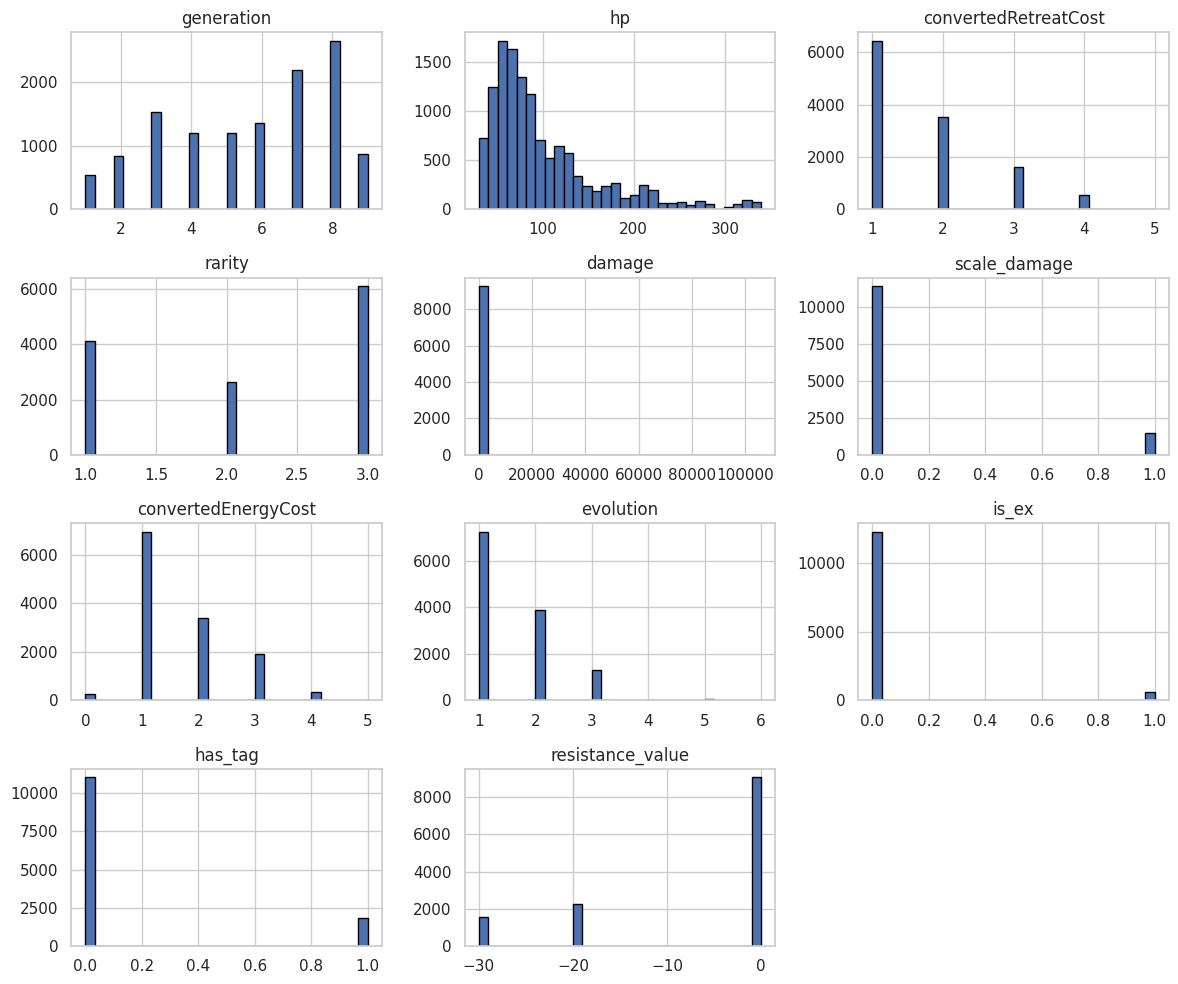

In [12]:
plotDF = pd.concat([X_imputed, y], axis=1)
df.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.tight_layout()
plt.show()

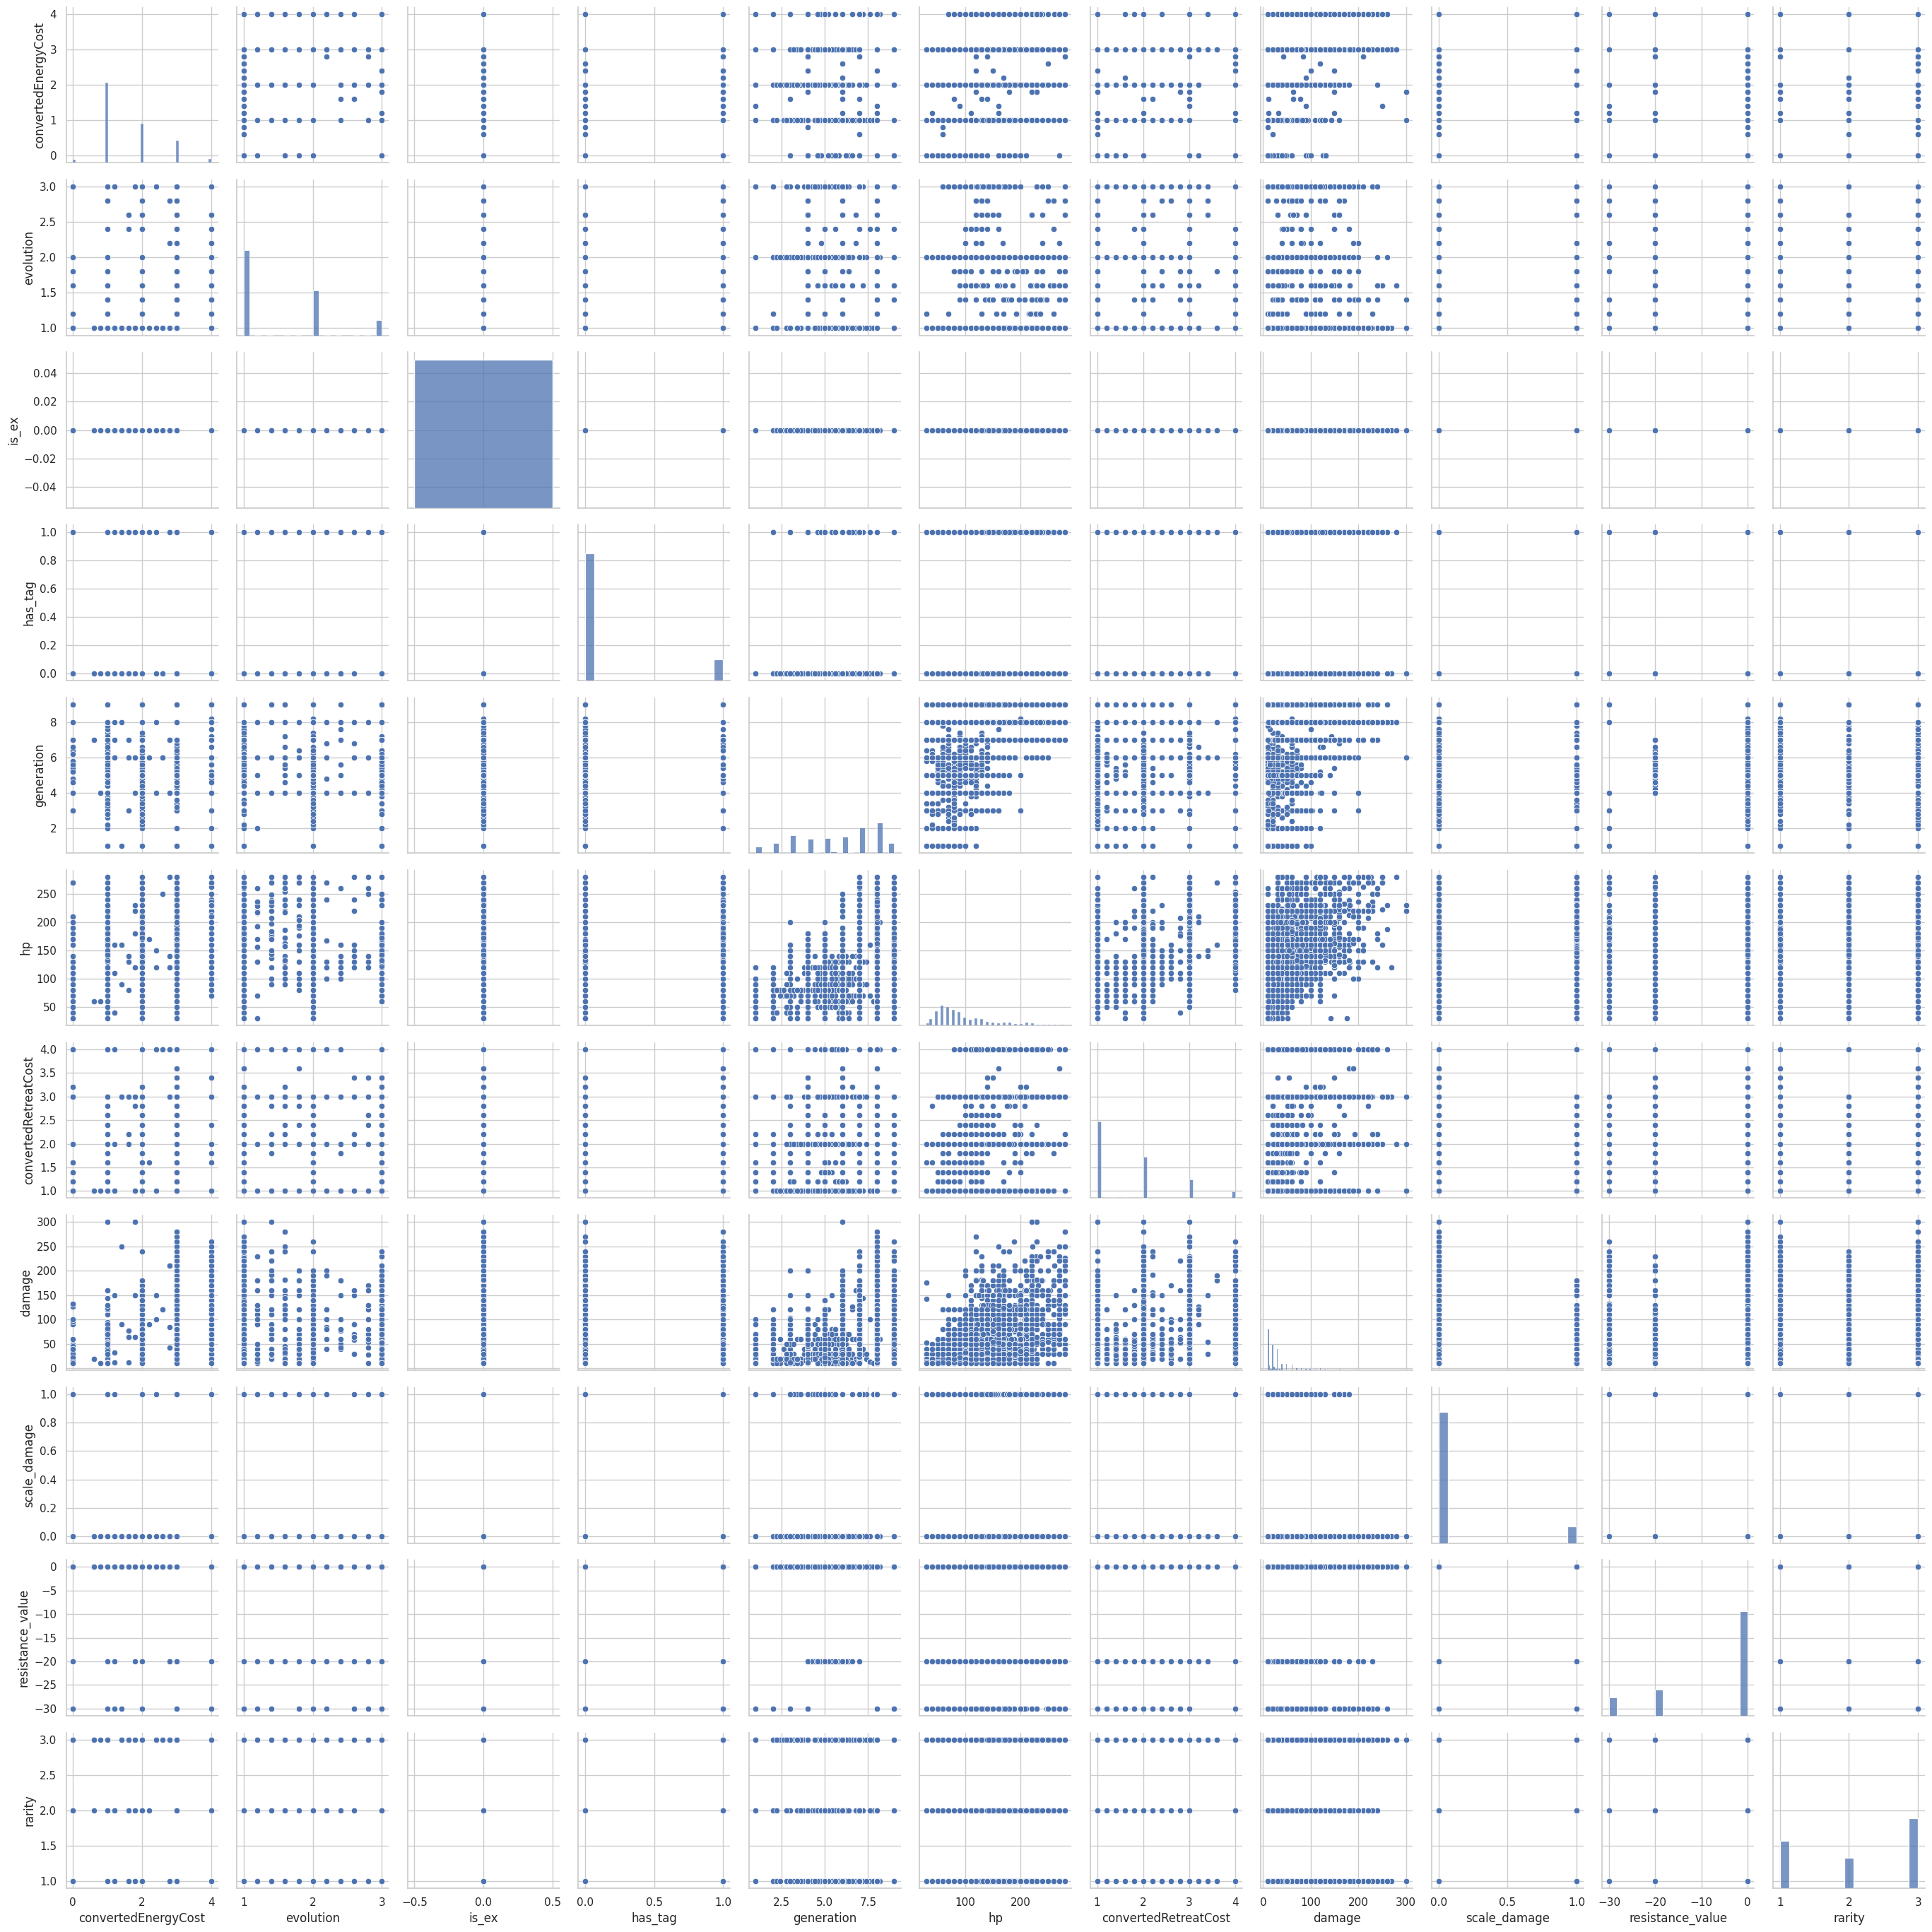

In [13]:
sns.pairplot(plotDF)
plt.tight_layout()
plt.show()

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [15]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}, PCA components: {X_pca.shape[1]}")


Original features: 10, PCA components: 8


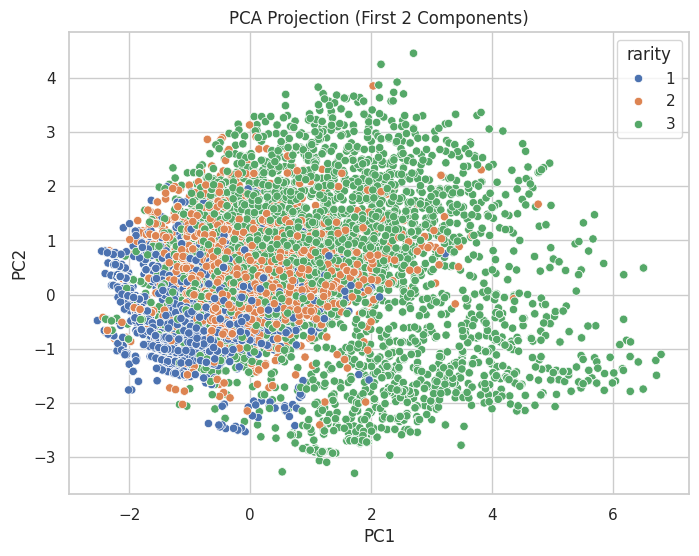

In [16]:
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['rarity'] = y.reset_index(drop=True)

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='rarity', palette='deep')
plt.title("PCA Projection (First 2 Components)")
plt.show()


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42)


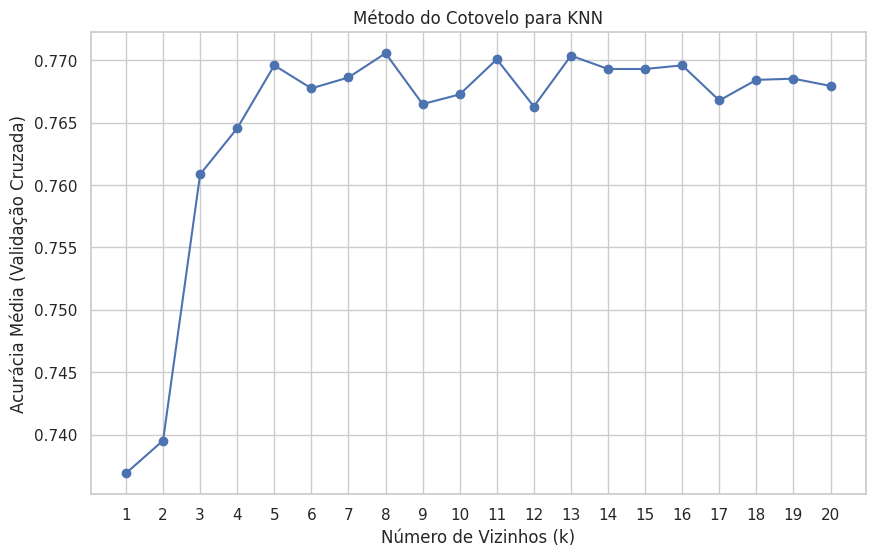

In [18]:
results = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    results.append(scores.mean())

# Plotar o gráfico
plt.figure(figsize=(10,6))
plt.plot(range(1, 21), results, marker='o')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia Média (Validação Cruzada)')
plt.title('Método do Cotovelo para KNN')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

In [19]:
param_grid = {'n_neighbors': list(range(1, 21))}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k: {best_k}, CV accuracy: {grid_search.best_score_:.4f}")


Best k: 8, CV accuracy: 0.7705


KNN Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.89      0.85       827
           2       0.56      0.55      0.55       531
           3       0.83      0.78      0.80      1222

    accuracy                           0.77      2580
   macro avg       0.73      0.74      0.73      2580
weighted avg       0.77      0.77      0.77      2580



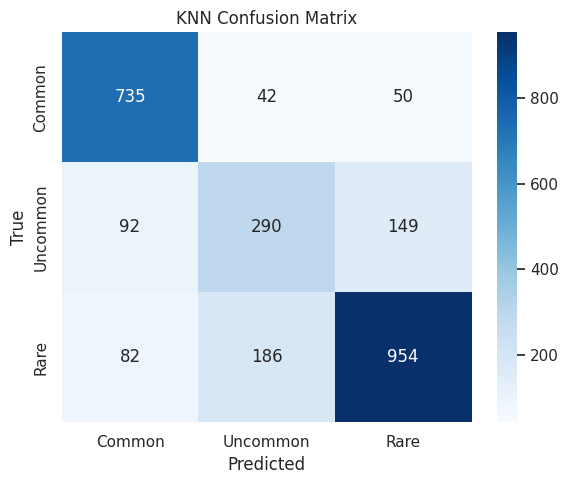

In [20]:
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Relatório de classificação
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# Matriz de confusão (numérica)
cm = confusion_matrix(y_test, y_pred_knn)

# Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Common', 'Uncommon', 'Rare'],
            yticklabels=['Common', 'Uncommon', 'Rare'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()

In [21]:
results = []
for activation in ['logistic', 'relu', 'tanh']:
    for lr in [0.001, 0.01, 0.1]:
        mlp = MLPClassifier(hidden_layer_sizes=(50,50),
                            activation=activation, solver='adam',
                            learning_rate='adaptive', learning_rate_init=lr,
                            alpha=0.01, batch_size=64, max_iter=50,
                            early_stopping=True, random_state=42)
        mlp.fit(X_train, y_train)
        acc = mlp.score(X_test, y_test)
        print(f"{activation}, lr={lr}: accuracy={acc:.2f}")
        results.append((activation, lr, acc))


logistic, lr=0.001: accuracy=0.78
logistic, lr=0.01: accuracy=0.77
logistic, lr=0.1: accuracy=0.78
relu, lr=0.001: accuracy=0.80
relu, lr=0.01: accuracy=0.79
relu, lr=0.1: accuracy=0.77
tanh, lr=0.001: accuracy=0.77
tanh, lr=0.01: accuracy=0.79
tanh, lr=0.1: accuracy=0.76


In [23]:
best_activation, best_lr, best_acc = max(results, key=lambda x: x[2])
print("Best MLP config:", best_activation, "lr=", best_lr)

mlp_best = MLPClassifier(hidden_layer_sizes=(50,50),
                         activation=best_activation, solver='adam',
                         learning_rate='adaptive', learning_rate_init=best_lr,
                         alpha=0.01, batch_size=64, max_iter=50,
                         early_stopping=True, random_state=42)
mlp_best.fit(X_train, y_train)
y_pred_mlp = mlp_best.predict(X_test)

print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp, zero_division=0))
print("MLP Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))


Best MLP config: relu lr= 0.001
MLP Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.93      0.87       827
           2       0.61      0.54      0.58       531
           3       0.85      0.82      0.83      1222

    accuracy                           0.80      2580
   macro avg       0.76      0.76      0.76      2580
weighted avg       0.79      0.80      0.79      2580

MLP Confusion Matrix:
[[770  30  27]
 [ 95 287 149]
 [ 75 150 997]]


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores hiperparâmetros encontrados:
{'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (40,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_iter': 100, 'solver': 'sgd'}
Acurácia média na validação cruzada: 0.7931
[[ 760   39   28]
 [  83  258  190]
 [  76  117 1029]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


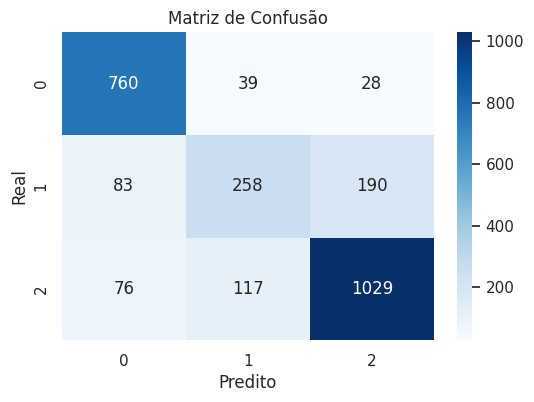

Relatório de classificação (precision, recall, f1-score, support):
              precision    recall  f1-score   support

           1     0.8270    0.9190    0.8706       827
           2     0.6232    0.4859    0.5460       531
           3     0.8252    0.8421    0.8335      1222

    accuracy                         0.7934      2580
   macro avg     0.7585    0.7490    0.7500      2580
weighted avg     0.7842    0.7934    0.7862      2580



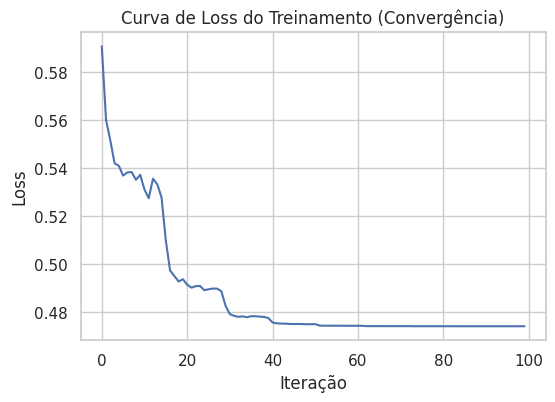

Número de iterações até a convergência: 100


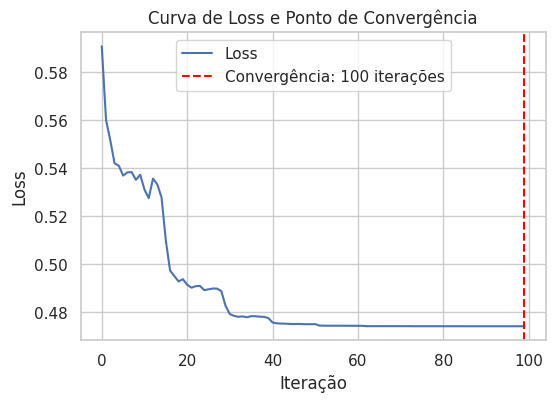

In [30]:
mlp = MLPClassifier(random_state=42, early_stopping=True)
param_grid = {
    'hidden_layer_sizes': [(80,), (40,)], #número de neurônios nas camadas ocultas
    'solver': ['adam', 'sgd', 'lbfgs'], #algoritmo para otimização
    'activation': ['relu', 'tanh', 'logistic'], #Função de ativação das camadas ocultas
    'learning_rate_init': [0.001, 0.01, 0.1], #Taxa de aprendizado inicial do otimizador.
    'max_iter': [100], #Número máximo de épocas/iterações.
    'batch_size': [32], #Tamanho do lote para atualização dos pesos.
    'learning_rate': ['constant', 'adaptive'] #Esquema de ajuste da taxa de aprendizado.
}
grid_search = GridSearchCV(
    mlp,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)
print(f"Acurácia média na validação cruzada: {grid_search.best_score_:.4f}")
y_pred_mlp = best_mlp.predict(X_test)
print(confusion_matrix(y_test, y_pred_mlp))

# Plot da matriz de confusão
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Tabela de métricas de classificação
report = classification_report(y_test, y_pred_mlp, digits=4)
print("Relatório de classificação (precision, recall, f1-score, support):")
print(report)

# === Ponto de convergência ===

# (1) Plotando a curva de loss durante o treino do melhor modelo
plt.figure(figsize=(6,4))
plt.plot(best_mlp.loss_curve_)
plt.xlabel('Iteração')
plt.ylabel('Loss')
plt.title('Curva de Loss do Treinamento (Convergência)')
plt.grid(True)
plt.show()

# (2) Exibindo o número de iterações até a convergência
print(f"Número de iterações até a convergência: {best_mlp.n_iter_}")

# (Opcional) Plotando uma linha indicando onde parou
plt.figure(figsize=(6,4))
plt.plot(best_mlp.loss_curve_, label='Loss')
plt.axvline(best_mlp.n_iter_-1, color='red', linestyle='--', label=f'Convergência: {best_mlp.n_iter_} iterações')
plt.xlabel('Iteração')
plt.ylabel('Loss')
plt.title('Curva de Loss e Ponto de Convergência')
plt.legend()
plt.grid(True)
plt.show()